In [1]:
#import modules
import numpy as np
from numpy import exp, pi
from numpy import linalg as LA
from numpy.fft import fft2, ifft2, fftshift
from matplotlib import pyplot as plt
from matplotlib.pyplot import rc
rc('text', usetex=True)
import cv2
#import files
import sys
sys.path.append('..')
from utils import matrix as mt
from utils import vamp

This notebook demonstrates Vector Approximate Message Passing in the setup of **Phase Retrieval**. (Environment : Python 3.11.2)  

### Setup  

**Phase Retrieval (PR)** is the problem of recovering a vector $\boldsymbol{x} \in \mathbb{C}^N$ from the component-wise magnitude of $\bm{z} = A\bm{x}$   $(\bm{z} \in \mathbb{C}^M\ , A \in \mathbb{C}^{M \times N})$. We consider a Bayesian formulation of phase retrieval. Assume Gaussian prior $p_{\text{in}}(\boldsymbol{x}) = \mathcal{N} (\boldsymbol{x} | \boldsymbol{0}, I_N)$. The observation vector $\boldsymbol{y} \in \mathbb{R}^M$ is modeled as  

$\boldsymbol{y} = |\boldsymbol{z} + \boldsymbol{w}|$  

where $\bm{z} = A\bm{x}$ and $\boldsymbol{w} \sim \mathcal{N} (\boldsymbol{w} | \boldsymbol{0}, \gamma_w ^{-1} I_N)$. The corresponding likelihood function $p_{\text{out}}(\boldsymbol{y} | |\boldsymbol{z}|) = \prod_{\mu = 1}^M p_{\text{out}}(y_{\mu} | |{z}_{\mu}|)$ is referred to as the *Rician* distribution. The Bayes rule is stated as  

$
p(\boldsymbol{x}, \boldsymbol{z} | \boldsymbol{y}) \propto p_{\text{in}}(\boldsymbol{x})\  \delta(\boldsymbol{z} - A\boldsymbol{x})\  p_{\text{out}}(\boldsymbol{y} | |\boldsymbol{z}|)
$



In [2]:
#data generation
def PR_data_generation(A, gamma_w):
    #input : A = (M * N) sensing matrix, gamma_w = noise precision
    #output : x = complex N-vector , y = observation
    N,M = len(A[0]), len(A)
    x = mt.complex_gaussian_vector(N,1)
    y = np.abs(A@x + mt.complex_gaussian_vector(M, 1/gamma_w))
    return x, y

### Numerical experiment 1.  
We test the phase retrieval algorithm with i.i.d. Gaussian sensing matrix $A$ : $A_{ij} \sim \mathcal{N}(0, 1/N)$

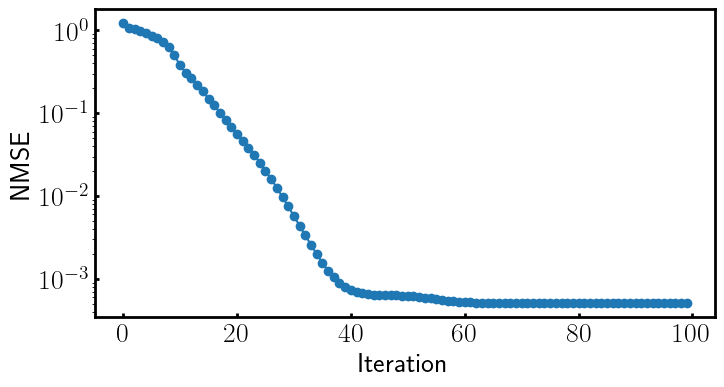

In [3]:
#data condition
N = 1024 # dimension of x
alpha = 2.4 # sampling ratio
M = int(N * alpha) # dimension of y
gamma_w = 1e4 #noise precision

#data generation
A = mt.complex_gaussian_matrix(M, N, 1/N) #i.i.d. gaussian matrix
x, y = PR_data_generation(A, gamma_w)

#algorithm condition
damping = 0.9
Kit = 100 # maximum number of iterations

#run VAMP
error = vamp.PR_VAMP(x, y, A, gamma_w, damping, Kit)

#show results
fig, ax = plt.subplots(1,1, figsize=(8, 4))
plt.tick_params(direction="in", length=3, width=2, labelsize=20)
ax.spines["right"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)
ax.spines["top"].set_linewidth(2)
ax.spines["bottom"].set_linewidth(2)
ax.plot(error, marker = "o")
ax.set_xlabel("Iteration", fontsize = 20)
ax.set_ylabel("NMSE", fontsize = 20)
ax.set_yscale('log')

### Numerical experiment 2
If $A$ is known to be orthogonal ( i.e. $A^H A = I_N$ ), pre-computation of singular value decomposition is unnecessary.

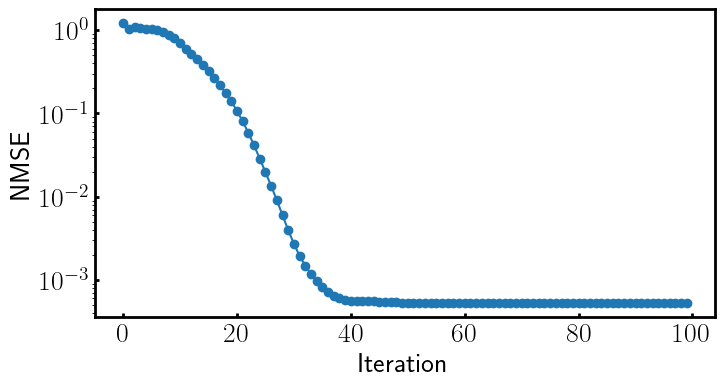

In [4]:
#data condition
N = 1024 # dimension of x
alpha  = 2.7 # sampling ratio
M = int(N * alpha) # dimension of y
gamma_w = 1e4 # noise precision

#data generation
A = mt.unitary(M)[:, :N] #Haar distributed sensing matrix
x, y = PR_data_generation(A, gamma_w)

#algorithm condition
damping = 0.9
Kit = 100 # maximum number of iterations

#run VAMP
error = vamp.PR_orthogonal_VAMP(x, y, A, gamma_w, damping, Kit)

#show results
fig, ax = plt.subplots(1,1, figsize=(8, 4))
plt.tick_params(direction="in", length=3, width=2, labelsize=20)
ax.spines["right"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)
ax.spines["top"].set_linewidth(2)
ax.spines["bottom"].set_linewidth(2)
ax.plot(error, marker = "o")
ax.set_xlabel("Iteration", fontsize = 20)
ax.set_ylabel("NMSE", fontsize = 20)
ax.set_yscale('log')

### References  
- **VAMP for generalized linear model**  
P. Schniter, S. Rangan and A. K. Fletcher, "Vector approximate message passing for the generalized linear model," 2016 50th Asilomar Conference on Signals, Systems and Computers  
- **Denoising function for Rician likelihood**  
P. Schniter and S. Rangan, "Compressive phase retrieval via generalized approximate message passing," 2012 50th Annual Allerton Conference on Communication, Control, and Computing (Allerton)  
- **Introduction to random matrix ensembles**  
Potters M, Bouchaud J-P. "A First Course in Random Matrix Theory: For Physicists, Engineers and Data Scientists". Cambridge University Press; 2020  
- **Sufficient sampling ratio for phase retrieval**  
Antoine Maillard, Bruno Loureiro, Krzakala Florent, and Lenka Zdeborová, "Phase retrieval in high dimensions: statistical and computational phase transitions". In Proceedings of the 34th International Conference on Neural Information Processing Systems (NIPS '20)